In [3]:
import pandas as pd
import numpy as np
import torch
import torch_geometric
import torch_scatter
import torch_sparse
import torch_cluster
import torch_spline_conv


### Data Load

In [4]:
df=pd.read_csv('fraud_payment_data.csv')

In [5]:
# Display the first few rows
print("First few rows of the dataset:")
print(df.head())

# Display dataset information
print("\nDataset Information:")
print(df.info())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check for duplicates
print("\nNumber of Duplicate Rows:")
print(df.duplicated().sum())

# Display basic statistics for numerical columns
print("\nBasic Statistics:")
print(df.describe())

# Display unique values count for categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
print("\nUnique Values in Categorical Columns:")
for col in categorical_columns:
    print(f"{col}: {df[col].nunique()} unique values")

First few rows of the dataset:
             Time_step       Transaction_Id          Sender_Id Sender_Account  \
0  2022-03-15 10:24:00       EXCHANGE-10115  JPMC-CLIENT-10098  ACCOUNT-10108   
1  2022-03-15 10:24:00  QUICK-PAYMENT-10116  JPMC-CLIENT-10098  ACCOUNT-10109   
2  2022-03-15 10:24:00    DEPOSIT-CASH-9833                NaN            NaN   
3  2022-03-15 10:24:00       PAY-CHECK-9832   JPMC-CLIENT-9812   ACCOUNT-9825   
4  2022-03-15 10:24:00   DEPOSIT-CHECK-9806                NaN            NaN   

  Sender_Country  Sender_Sector Sender_lob           Bene_Id   Bene_Account  \
0            USA        35537.0        CCB               NaN            NaN   
1            USA        15287.0        CCB      CLIENT-10100  ACCOUNT-10106   
2            NaN            NaN        NaN  JPMC-CLIENT-9812   ACCOUNT-9826   
3            USA        38145.0        CCB  JPMC-CLIENT-9814   ACCOUNT-9824   
4            NaN            NaN        NaN  JPMC-CLIENT-9789   ACCOUNT-9800   

  Bene_

In [ ]:
# Drop rows where Sender_Id or Bene_Id is missing 
df_cleaned = df.dropna(subset=['Sender_Id', 'Bene_Id'])

# Filling missing categorical values with "Unknown"
categorical_cols = ['Sender_Account', 'Sender_Country', 'Sender_lob', 
                    'Bene_Account', 'Bene_Country']
df_cleaned.loc[:, categorical_cols] = df_cleaned[categorical_cols].fillna("Unknown")

# Filling missing numerical values with the median
df_cleaned.loc[:, 'Sender_Sector'] = df_cleaned.loc[:, 'Sender_Sector'].fillna(df_cleaned['Sender_Sector'].median())

# Check again for missing values
print("Missing values after cleaning:")
print(df_cleaned.isnull().sum())


Missing values after cleaning:
Time_step           0
Transaction_Id      0
Sender_Id           0
Sender_Account      0
Sender_Country      0
Sender_Sector       0
Sender_lob          0
Bene_Id             0
Bene_Account        0
Bene_Country        0
USD_amount          0
Label               0
Transaction_Type    0
dtype: int64


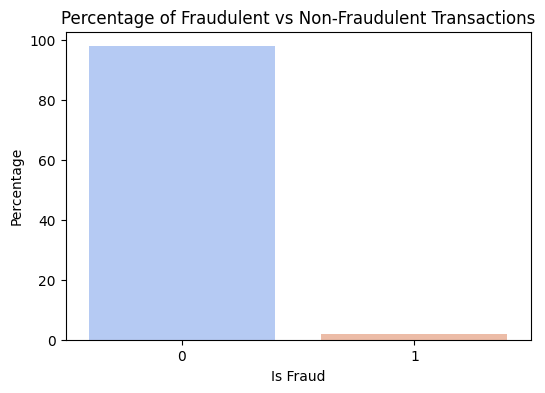

In [87]:
# Calculate the percentage of fraud and non-fraud transactions
fraud_percentage = df_cleaned['Label'].value_counts(normalize=True) * 100

# Prepare the data for plotting
fraud_percentage_df = fraud_percentage.reset_index()
fraud_percentage_df.columns = ['Is Fraud', 'Percentage']

# Plot the percentage of fraud and non-fraud transactions
plt.figure(figsize=(6, 4))
sns.barplot(data=fraud_percentage_df, x='Is Fraud', y='Percentage', palette='coolwarm', hue='Is Fraud', dodge=False, legend=False)
plt.title("Percentage of Fraudulent vs Non-Fraudulent Transactions")
plt.xlabel("Is Fraud")
plt.ylabel("Percentage")
plt.show()

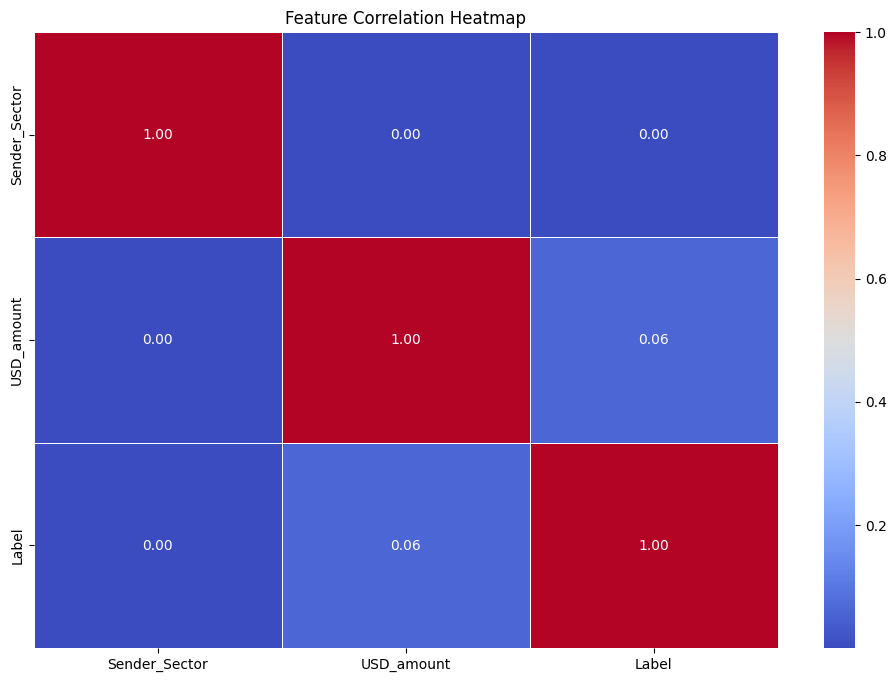

In [34]:
# Exclude non-numeric columns
df_numeric = df_cleaned.select_dtypes(include=[np.number])

# Generate the feature correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

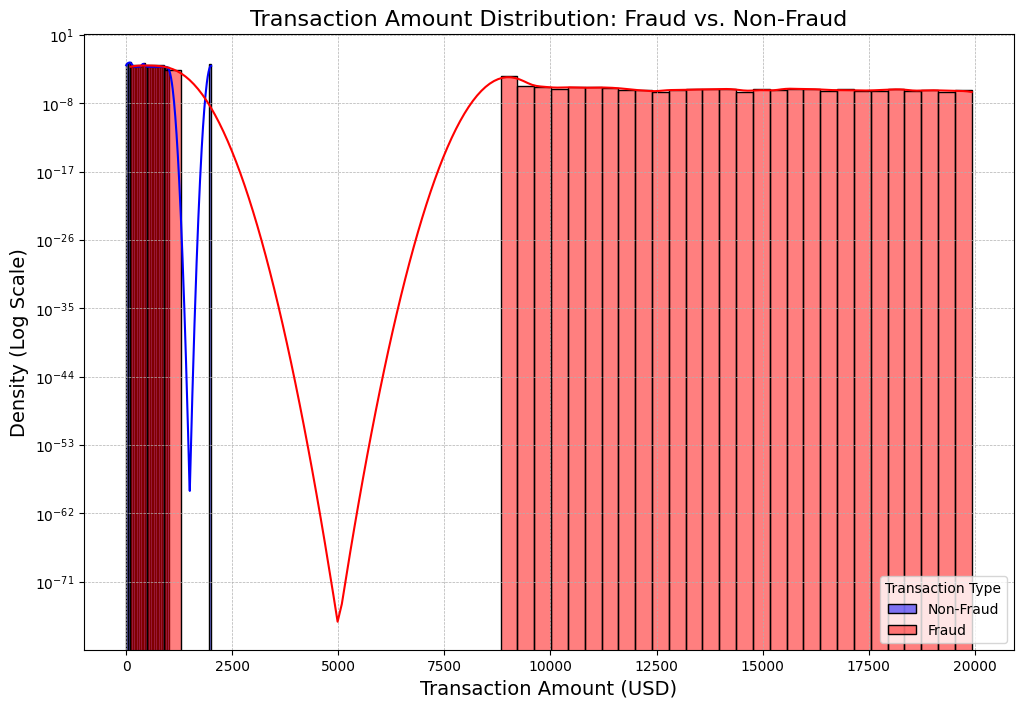

In [40]:
plt.figure(figsize=(12, 8))

# Plot non-fraud transactions
sns.histplot(df_cleaned[df_cleaned['Label'] == 0]['USD_amount'], bins=50, color='blue', label='Non-Fraud', kde=True, stat="density", common_norm=False)

# Plot fraud transactions
sns.histplot(df_cleaned[df_cleaned['Label'] == 1]['USD_amount'], bins=50, color='red', label='Fraud', kde=True, stat="density", common_norm=False)

# Log scale for better visualization
plt.yscale('log')
plt.xlabel("Transaction Amount (USD)", fontsize=14)
plt.ylabel("Density (Log Scale)", fontsize=14)
plt.title("Transaction Amount Distribution: Fraud vs. Non-Fraud", fontsize=16)
plt.legend(title="Transaction Type")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

### Graph Builder

In [41]:
import networkx as nx
import pickle

# Create a directed graph
G = nx.DiGraph()

# Add edges (transactions) between sender and beneficiary
for _, row in df_cleaned.iterrows():
    G.add_edge(row['Sender_Id'], row['Bene_Id'], 
               transaction_id=row['Transaction_Id'],
               amount=row['USD_amount'],
               transaction_type=row['Transaction_Type'],
               time_step=row['Time_step'],
               label=row['Label'])



# Print graph information
print(f"Number of nodes (unique senders + beneficiaries): {G.number_of_nodes()}")
print(f"Number of edges (transactions): {G.number_of_edges()}")

# Save the graph using pickle
with open("fraud_graph.pkl", "wb") as f:
    pickle.dump(G, f)

print("Graph saved successfully as fraud_graph.pkl")


Number of nodes (unique senders + beneficiaries): 288017
Number of edges (transactions): 319203
Graph saved successfully as fraud_graph.pkl


### Feature Engineering

##### 1. In-Degree & Out-Degree

These features capture the number of incoming and outgoing transactions for each node (account/user).
	•	In-Degree (in_degree): The number of incoming transactions to a node.
	•	A high value may indicate a receiver receiving funds from multiple sources (potential fraud).
	•	Out-Degree (out_degree): The number of outgoing transactions from a node.
	•	High values may indicate a user distributing money to many accounts, potentially a fraudster dispersing illicit funds.

##### 2. PageRank Score

PageRank measures the importance of a node in the network.
	•	PageRank (pagerank): Higher values indicate nodes that receive transactions from many well-connected users.
	•	Fraudsters may have low PageRank (isolated accounts) or high PageRank (if controlling large transaction flows).

##### 3. Betweenness Centrality

Betweenness Centrality captures how often a node acts as a bridge in the transaction network.
	•	Betweenness Centrality (betweenness): Measures a node’s importance in connecting different parts of the network.
	•	Fraudsters might have high betweenness if they act as intermediaries in money laundering schemes.
	•	Genuine users generally have low betweenness, following typical transaction patterns.

##### 4. Transaction Amount Statistics

These features analyze the distribution of transaction amounts per node.
	•	Mean Transaction Amount (mean_amount): The average transaction value of a node.
	•	Fraudulent accounts often have extreme values (either very small or very large).
	•	Standard Deviation of Transaction Amount (std_amount): Measures the variation in transaction amounts.
	•	High variability might indicate inconsistent and suspicious transaction patterns.

##### 5. Fraud Score

The fraud score captures the number of fraudulent transactions a node is involved in.
	•	Fraud Score (fraud_score): The number of fraudulent transactions received by a node.
	•	A high fraud score suggests the account is frequently interacting with fraudulent entities.

In [8]:

# Extract in-degree and out-degree
degree_features = {
    node: {
        "in_degree": G.in_degree(node),
        "out_degree": G.out_degree(node)
    }
    for node in G.nodes()
}

# Convert to DataFrame
df_graph_features = pd.DataFrame.from_dict(degree_features, orient="index")
df_graph_features.index.name = "Node"

# Compute PageRank
pagerank = nx.pagerank(G)
df_graph_features["pagerank"] = df_graph_features.index.map(pagerank)

# Compute Betweenness Centrality (Takes time for large graphs)
betweenness = nx.betweenness_centrality(G, k=500)  # Approximate for large graphs
df_graph_features["betweenness"] = df_graph_features.index.map(betweenness)

amounts = {}
for sender, receiver, data in G.edges(data=True):
    if sender not in amounts:
        amounts[sender] = []
    amounts[sender].append(data["amount"])

amount_stats = {
    node: {
        "mean_amount": (sum(amounts[node]) / len(amounts[node])) if node in amounts else 0,
        "std_amount": (pd.Series(amounts[node]).std() if node in amounts and len(amounts[node]) > 1 else 0)
    }
    for node in G.nodes()
}

df_amount_stats = pd.DataFrame.from_dict(amount_stats, orient="index")
df_graph_features = df_graph_features.join(df_amount_stats)

# Compute fraud score (number of fraudulent transactions per node)
fraud_scores = {
    node: sum(1 for _, _, d in G.in_edges(node, data=True) if d["label"] == 1)
    for node in G.nodes()
}
df_graph_features["fraud_score"] = df_graph_features.index.map(fraud_scores)

# Save graph features for GNN model
df_graph_features.to_csv("graph_features_for_gnn.csv", index=True)


In [9]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

for node, features in df_graph_features.iterrows():
    for feature_name, feature_value in features.items():
        G.nodes[node][feature_name] = feature_value

# Convert to PyTorch Geometric format
graph_data = from_networkx(G, group_node_attrs=list(df_graph_features.columns))

# Print graph data details
print(graph_data)

Data(edge_index=[2, 319203], transaction_id=[319203], amount=[319203], transaction_type=[319203], time_step=[319203], label=[319203], x=[288017, 7])


### Modeling

##### GCN (Graph Convolutional Network): Aggregates features from neighboring nodes but treats all neighbors equally.

In [61]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class FraudGCN(nn.Module):
    def __init__(self, in_features, hidden_dim, out_features):
        super(FraudGCN, self).__init__()
        self.conv1 = GCNConv(in_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_features)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the model with correct feature dimension
model = FraudGCN(in_features=graph_data.num_node_features, hidden_dim=32, out_features=2)

print(model)

FraudGCN(
  (conv1): GCNConv(7, 32)
  (conv2): GCNConv(32, 2)
)


In [62]:
import numpy as np

# Initialize node labels (default to non-fraudulent 0)
node_labels = {node: 0 for node in G.nodes()}

# Assign fraud labels: If a node is involved in any fraud (Label=1), mark it as fraud
for sender, receiver, data in G.edges(data=True):
    if data["label"] == 1:  # Fraudulent transaction
        node_labels[sender] = 1
        node_labels[receiver] = 1

# Convert labels into tensor format
node_label_list = [node_labels[node] for node in G.nodes()]
y = torch.tensor(node_label_list, dtype=torch.long)

print("Node Labels Assigned Successfully!")
print(f"Fraudulent Nodes: {sum(y.numpy())}, Total Nodes: {len(y)}")

Node Labels Assigned Successfully!
Fraudulent Nodes: 7246, Total Nodes: 288017


In [ ]:
import random 
SEED = 42  # Set seed for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
from sklearn.model_selection import train_test_split


num_nodes = graph_data.x.shape[0]

# Ensure y matches the number of nodes
assert len(y) == num_nodes, "Mismatch between node count and label count!"

# Create train-test split (80-20 split)
train_indices, test_indices = train_test_split(
    np.arange(num_nodes), test_size=0.2, random_state=42, stratify=y.numpy()
)

# Convert to boolean mask
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True
test_mask[test_indices] = True

# Move data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X, y = graph_data.x.to(device), y.to(device)
train_mask, test_mask = train_mask.to(device), test_mask.to(device)

print(f"Training Nodes: {train_mask.sum().item()}, Testing Nodes: {test_mask.sum().item()}")

Training Nodes: 230413, Testing Nodes: 57604


In [ ]:
import torch.optim as optim

# model to GPU if available
model = model.to(device)
# Compute class weights (Inverse frequency of labels)
fraud_weight = len(y) / (2 * sum(y.cpu().numpy() == 1))
normal_weight = len(y) / (2 * sum(y.cpu().numpy() == 0))
weights = torch.tensor([normal_weight, fraud_weight], dtype=torch.float).to(device)

# Update loss function with class weights
criterion = nn.NLLLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Train the model
num_epochs = 200
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Forward pass
    out = model(X, graph_data.edge_index)
    
    # Compute loss on training nodes only
    loss = criterion(out[train_mask], y[train_mask])
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

print("Training Complete!")

Epoch 0, Loss: 93.57782745361328
Epoch 10, Loss: 5.609402656555176
Epoch 20, Loss: 1.5679869651794434
Epoch 30, Loss: 1.8228111267089844
Epoch 40, Loss: 1.1825915575027466
Epoch 50, Loss: 0.9747011661529541
Epoch 60, Loss: 0.8200784921646118
Epoch 70, Loss: 0.646865963935852
Epoch 80, Loss: 0.7627415657043457
Epoch 90, Loss: 0.6824185848236084
Epoch 100, Loss: 0.7134673595428467
Epoch 110, Loss: 0.6224930286407471
Epoch 120, Loss: 0.5294090509414673
Epoch 130, Loss: 0.7052764892578125
Epoch 140, Loss: 0.8814350962638855
Epoch 150, Loss: 0.493413507938385
Epoch 160, Loss: 0.47510313987731934
Epoch 170, Loss: 0.4781036972999573
Epoch 180, Loss: 0.4782753586769104
Epoch 190, Loss: 0.4552902579307556
Training Complete!


In [66]:
from sklearn.metrics import classification_report, roc_auc_score

model.eval()
with torch.no_grad():
    predictions = model(X, graph_data.edge_index).argmax(dim=1)

# Extract test predictions
y_test_pred = predictions[test_mask]
y_test_true = y[test_mask].cpu().numpy()
y_test_pred = y_test_pred.cpu().numpy()

# Compute evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test_true, y_test_pred))

# Compute AUC-ROC score
y_test_proba = model(X, graph_data.edge_index)[test_mask][:, 1].exp().detach().cpu().numpy()
print("\nAUC-ROC Score:", roc_auc_score(y_test_true, y_test_proba))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     56155
           1       0.16      0.64      0.26      1449

    accuracy                           0.91     57604
   macro avg       0.58      0.78      0.61     57604
weighted avg       0.97      0.91      0.93     57604


AUC-ROC Score: 0.9207225035654112


##### GAT (Graph Attention Network): Uses attention to assign different importance to neighbors, improving performance.

In [ ]:
SEED = 42  
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [76]:
from torch_geometric.nn import GATConv

class FraudGAT(nn.Module):
    def __init__(self, in_features, hidden_dim, out_features, heads=4):
        super(FraudGAT, self).__init__()
        self.conv1 = GATConv(in_features, hidden_dim, heads=heads, concat=True)
        self.conv2 = GATConv(hidden_dim * heads, out_features, heads=1, concat=False)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize GAT model
Gatmodel = FraudGAT(in_features=graph_data.num_node_features, hidden_dim=32, out_features=2).to(device)

In [ ]:

weights = torch.tensor([normal_weight, fraud_weight], dtype=torch.float).to(device)

# Update loss function with class weights
criterion = nn.NLLLoss(weight=weights)
optimizer = optim.Adam(Gatmodel.parameters(), lr=0.01, weight_decay=5e-4)


# Train the model
num_epochs = 200
Gatmodel.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Forward pass
    out = Gatmodel(X, graph_data.edge_index)
    
    # Compute loss on training nodes only
    loss = criterion(out[train_mask], y[train_mask])
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

print("Training Complete!")

Epoch 0, Loss: 187.38449096679688
Epoch 10, Loss: 18.783374786376953
Epoch 20, Loss: 7.81110954284668
Epoch 30, Loss: 5.2938666343688965
Epoch 40, Loss: 4.893676280975342
Epoch 50, Loss: 2.654440402984619
Epoch 60, Loss: 2.1111629009246826
Epoch 70, Loss: 0.8588579297065735
Epoch 80, Loss: 0.460626482963562
Epoch 90, Loss: 0.5502326488494873
Epoch 100, Loss: 0.3083428144454956
Epoch 110, Loss: 0.23085801303386688
Epoch 120, Loss: 0.25278806686401367
Epoch 130, Loss: 0.3355812430381775
Epoch 140, Loss: 0.2250116616487503
Epoch 150, Loss: 0.22721369564533234
Epoch 160, Loss: 0.24717727303504944
Epoch 170, Loss: 0.2146998941898346
Epoch 180, Loss: 0.21016022562980652
Epoch 190, Loss: 0.23857757449150085
Training Complete!


In [78]:
Gatmodel.eval()
with torch.no_grad():
    predictions = Gatmodel(X, graph_data.edge_index).argmax(dim=1)

# Extract test predictions
y_test_pred = predictions[test_mask]
y_test_true = y[test_mask].cpu().numpy()
y_test_pred = y_test_pred.cpu().numpy()

# Compute evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test_true, y_test_pred))

# Compute AUC-ROC score
y_test_proba = Gatmodel(X, graph_data.edge_index)[test_mask][:, 1].exp().detach().cpu().numpy()
print("\nAUC-ROC Score:", roc_auc_score(y_test_true, y_test_proba))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     56155
           1       0.19      0.97      0.32      1449

    accuracy                           0.90     57604
   macro avg       0.59      0.93      0.63     57604
weighted avg       0.98      0.90      0.93     57604


AUC-ROC Score: 0.9789820937672574


### More complex structure to learn more features but lead to overfitting 

In [18]:
from torch_geometric.nn import GATConv

class DeepGAT(nn.Module):
    def __init__(self, in_features, hidden_dim, out_features, heads=3, num_layers=3, dropout=0.5):
        super(DeepGAT, self).__init__()
        self.convs = nn.ModuleList()
        
        # First GAT layer
        self.convs.append(GATConv(in_features, hidden_dim, heads=heads, concat=True))
        
        # Intermediate GAT layers
        for _ in range(num_layers - 2):
            self.convs.append(GATConv(hidden_dim * heads, hidden_dim, heads=heads, concat=True))
        
        # Final GAT layer (heads=1, concat=False for 2-class output)
        self.convs.append(GATConv(hidden_dim * heads, out_features, heads=1, concat=False))
        
        self.dropout = dropout

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = F.elu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return F.log_softmax(x, dim=1)

In [19]:
DeepGATModel = DeepGAT(in_features=graph_data.num_node_features, hidden_dim=32, out_features=2).to(device)

In [20]:
fraud_weight = len(y) / (2 * sum(y.cpu().numpy() == 1))
normal_weight = len(y) / (2 * sum(y.cpu().numpy() == 0))
weights = torch.tensor([normal_weight, fraud_weight], dtype=torch.float).to(device)

# Update loss function with class weights
criterion = nn.NLLLoss(weight=weights)
optimizer = optim.Adam(DeepGATModel.parameters(), lr=0.01, weight_decay=5e-4)




# Train the model
num_epochs = 100
DeepGATModel.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Forward pass
    out = DeepGATModel(X, graph_data.edge_index)
    
    # Compute loss on training nodes only
    loss = criterion(out[train_mask], y[train_mask])
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

print("Training Complete!")

Epoch 0, Loss: 159.06240844726562
Epoch 10, Loss: 7.88917875289917
Epoch 20, Loss: 2.1641170978546143
Epoch 30, Loss: 1.114905834197998
Epoch 40, Loss: 0.7169594168663025
Epoch 50, Loss: 0.5263640284538269
Epoch 60, Loss: 0.40501868724823
Epoch 70, Loss: 0.35958367586135864
Epoch 80, Loss: 0.3217070996761322
Epoch 90, Loss: 0.31498077511787415
Training Complete!


In [21]:
DeepGATModel.eval()
with torch.no_grad():
    predictions = DeepGATModel(X, graph_data.edge_index).argmax(dim=1)

# Extract test predictions
y_test_pred = predictions[test_mask]
y_test_true = y[test_mask].cpu().numpy()
y_test_pred = y_test_pred.cpu().numpy()

# Compute evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test_true, y_test_pred))

# Compute AUC-ROC score
y_test_proba = DeepGATModel(X, graph_data.edge_index)[test_mask][:, 1].exp().detach().cpu().numpy()
print("\nAUC-ROC Score:", roc_auc_score(y_test_true, y_test_proba))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     56155
           1       0.14      1.00      0.24      1449

    accuracy                           0.84     57604
   macro avg       0.57      0.92      0.58     57604
weighted avg       0.98      0.84      0.89     57604


AUC-ROC Score: 0.9529951758414902
